In [1]:
'''

多被试分析。
每个被试在对应指标上都是一个平均值。

'''
import  mne
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import numpy as np

In [4]:
data_path = 'E:\Python LYW\RSA\spaced_learning\pre10\\analysis\data\\6epoch_clean_equal\\'
list_O_ids = [
    'prex006','prex009','prex010','prex011','prex012',
    'prex015','prex016','prex017','prex018','prex019','prex022','prex023',
    'prex027','prex028',
    'prex033','prex037','prex038','prex040',
    'prex041','prex042','prex044','prex045',
    'prex046','prex047','prex049','prex050','prex052','prex051'
]
#去掉了 5和9被
list_M_ids = [
    'prex006M','prex009M','prex010M','prex011M','prex012M',
    'prex015M','prex016M','prex017M','prex018M','prex019M','prex022M','prex023M',
    'prex027M','prex028M',
    'prex033M','prex037M','prex038M','prex040S',
    'prex041M','prex042M','prex044M','prex045M'
    ,'prex046M','prex047M','prex049S','prex050M','prex052M','prex051M'

]

list_S_ids = [
    'prex006S','prex009S','prex010S','prex011S','prex012S',
    'prex015S','prex016S','prex017S','prex018S','prex019S','prex022S','prex023S',
    'prex027S','prex028S'
    ,'prex033S','prex037S','prex038S','prex040M'
    ,'prex041S','prex042S','prex044S','prex045S'
    ,'prex046S','prex047S','prex049M','prex050S','prex052S','prex051S'
]

list_epochs_O = list()
list_epochs_S = list()
list_epochs_M = list()


for sub_id_O, sub_id_M, sub_id_S in zip(list_O_ids, list_M_ids, list_S_ids):
    epochs_O = mne.read_epochs(data_path+sub_id_O+'-epo.fif')
    print(data_path+sub_id_O+'-epo.fif')
    epochs_M = mne.read_epochs(data_path+sub_id_M+'-epo.fif')
    epochs_S = mne.read_epochs(data_path+sub_id_S+'-epo.fif')
    list_epochs_O.append(epochs_O)
    list_epochs_M.append(epochs_M)
    list_epochs_S.append(epochs_S)


Reading E:\Python LYW\RSA\spaced_learning\pre10\analysis\data\6epoch_clean_equal\prex006-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
E:\Python LYW\RSA\spaced_learning\pre10\analysis\data\6epoch_clean_equal\prex006-epo.fif
Reading E:\Python LYW\RSA\spaced_learning\pre10\analysis\data\6epoch_clean_equal\prex006M-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Reading E:\Python LYW\RSA\spaced_learning\pre10\analysis\data\6epoch_clean_equal\prex006S-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
46 matching even

In [6]:
tmin = 0
tmax = 0.8
fmin = 1.
fmax = 35
sfreq = list_epochs_S[0].info['sfreq']

# 每个被试都对应一个 psds,freqs，那么还需要做两个list了。
# psds的数据结构是什么样子的呢，怎么进行统计分析呢？
#  (n_epochs, n_channels, n_freqs).
list_psds = list()
list_freqs = list()
list_snrs = list()
# if input is of type Epochs, then psds will be of shape (n_epochs, n_channels, n_freqs)
# psds的数据结构如此，那么可以考虑进行平均 SNR应该也是一样的道理。
# 每个被试的psds先平均，然后再把所有的被试的数据平均psds拼接起来。
channels = ['M1','T7','P7','TP7','M2','T8','P8','TP8','CP5','CP6','C5','C6']
channels_LTP = ['T7','P7', 'CP5']
for i in range(len(list_S_ids)):
    psds, freqs = mne.time_frequency.psd_welch(
        #关键设置 4 还是 30
        list_epochs_S[i],
        picks = channels_LTP,
        n_fft=int(sfreq * (tmax - tmin)),
        # n_fft= 1000,
        n_overlap=0, n_per_seg=None,
        tmin=tmin, tmax=tmax,
        fmin=fmin, fmax=fmax,
        window='boxcar',
        verbose=False,
        average = 'mean'
    )

    def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
        """Compute SNR spectrum from PSD spectrum using convolution.

        Parameters
        ----------
        psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
            Data object containing PSD values. Works with arrays as produced by
            MNE's PSD functions or channel/trial subsets.
        noise_n_neighbor_freqs : int
            Number of neighboring frequencies used to compute noise level.
            increment by one to add one frequency bin ON BOTH SIDES
        noise_skip_neighbor_freqs : int
            set this >=1 if you want to exclude the immediately neighboring
            frequency bins in noise level calculation

        Returns
        -------
        snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
            Array containing SNR for all epochs, channels, frequency bins.
            NaN for frequencies on the edges, that do not have enough neighbors on
            one side to calculate SNR.
        """
        # Construct a kernel that calculates the mean of the neighboring
        # frequencies
        averaging_kernel = np.concatenate((
            np.ones(noise_n_neighbor_freqs),
            np.zeros(2 * noise_skip_neighbor_freqs + 1),
            np.ones(noise_n_neighbor_freqs)))
        averaging_kernel /= averaging_kernel.sum()

        # Calculate the mean of the neighboring frequencies by convolving with the
        # averaging kernel.
        mean_noise = np.apply_along_axis(
            lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'),
            axis=-1, arr=psd
        )

        # The mean is not defined on the edges so we will pad it with nas. The
        # padding needs to be done for the last dimension only so we set it to
        # (0, 0) for the other ones.
        edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
        pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
        mean_noise = np.pad(
            mean_noise, pad_width=pad_width, constant_values=np.nan
        )

        return psd / mean_noise
    snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3,
                        noise_skip_neighbor_freqs=0)

    list_psds.append(psds)
    list_freqs.append(freqs)
    list_snrs.append(snrs)

In [8]:
'''
ndarray在某个方向上进行平均
'''
%matplotlib qt
psds_group = np.empty([len(list_S_ids),len(channels_LTP),28])
snrs_group = np.empty([len(list_S_ids),len(channels_LTP),28])
for i in range(len(list_S_ids)):
    psds_group[i]=np.mean(list_psds[i],axis=0)
    snrs_group[i]=np.mean(list_snrs[i],axis=0)

'''

'''
fig, axes = plt.subplots(2, 1, sharex='all', sharey='none', figsize=(8, 5))
freq_range = range(np.where(np.floor(freqs) == 1.)[0][0],
                   np.where(np.ceil(freqs) == fmax - 1)[0][0])

psds_plot = 10 * np.log10(psds_group)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color='b')
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std,
    color='b', alpha=.2)
axes[0].set(title="PSD spectrum", ylabel='Power Spectral Density [dB]')

# SNR spectrum
snr_mean = snrs_group.mean(axis=(0, 1))[freq_range]
snr_std = snrs_group.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color='r')
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std,
    color='r', alpha=.2)
axes[1].set(
    title="SNR spectrum", xlabel='Frequency [Hz]',
    ylabel='SNR', ylim=[-2, 10], xlim=[fmin, fmax])
fig.show()


In [ ]:
'''
读取不同分析时间的，在4Hz上的SNR，然后以时间为横轴，SNR为纵轴作图。

问题：为什么

'''




In [10]:
'''
时频分析
https://mne.tools/stable/auto_tutorials/time-freq/20_sensors_time_frequency.html#sphx-glr-auto-tutorials-time-freq-20-sensors-time-frequency-py

这里对应生成的是power和ITC，ITC肯定是一个被试一个了（试次间参数）。
ERSP可以选择（相对基线的扰动）。

那么最简单的想法：就是直接组平均，  power.data就是ndarray[channel，frequency，time]，那么同样的只要增加一个被试维度，平均一下就行了。
'''
freqs = np.logspace(*np.log10([1, 50]), num=8)
freqs = np.linspace(1,40,num=40)
n_cycles = freqs / 2.  # different number of cycle per frequency

#随便弄一个power出来备用。
power, itc = tfr_morlet(list_epochs_S[0], freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)
ndarry_power_group = np.empty([len(list_S_ids),63,40,167])
ndarry_itc_group = np.empty([len(list_S_ids),63,40,167])

for j in range(len(sub_id_S)):
    power, itc = tfr_morlet(list_epochs_S[j], freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)
    ndarry_power_group[j] = power.data
    ndarry_itc_group[j] = itc.data


In [11]:
ndarry_power_group_average = np.mean(ndarry_power_group,axis=0)
power.data = ndarry_power_group_average
%matplotlib qt
power.plot_topo(baseline=(-0.5, 0), mode='logratio', title='Average power', fmin=0,fmax=40, vmax=1.5,vmin=-1.5)
power.plot([33], baseline=(-0.5, 0), mode='logratio', title=power.ch_names[33])

fig, axis = plt.subplots(1, 2, figsize=(7, 4))
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=8, fmax=12,
                   baseline=(-0.5, 0), mode='logratio', axes=axis[0],
                   title='Alpha', show=False)
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=13, fmax=25,
                   baseline=(-0.5, 0), mode='logratio', axes=axis[1],
                   title='Beta', show=False)
mne.viz.tight_layout()
plt.show()

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


C:\Users\SilverBullet\AppData\Local\Temp\ipykernel_18048\3428265250.py:8: FutureWarning: The "title" parameter is deprecated and will be removed in version 1.3. Use "fig.suptitle()" instead.
  power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=8, fmax=12,
C:\Users\SilverBullet\AppData\Local\Temp\ipykernel_18048\3428265250.py:11: FutureWarning: The "title" parameter is deprecated and will be removed in version 1.3. Use "fig.suptitle()" instead.
  power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=13, fmax=25,


Applying baseline correction (mode: mean)


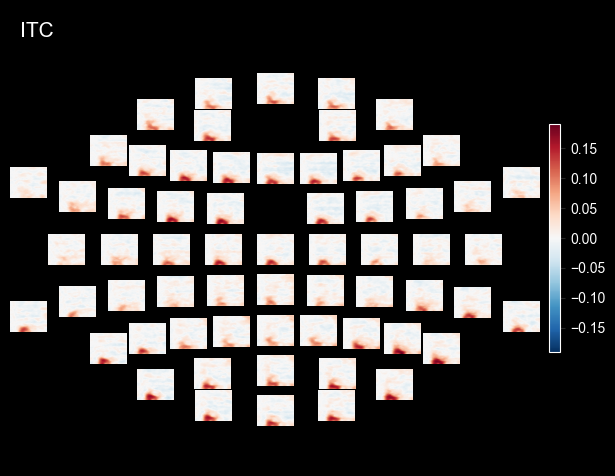

In [12]:
ndarry_itc_group_average = np.mean(ndarry_itc_group,axis=0)
itc.data = ndarry_itc_group_average
itc.plot_topo(baseline=(-0.5, 0), mode='mean', title='ITC')